# This notebook illustrates the usage of the GroundwaterDupuitPercolator Landlab component

The GroundwaterDupuitPercolator is a simple Landlab component that simulates a shallow, unconfined aquifer using the Dupuit approximation, also known as the shallow-aquifer approximation. This approximation treats the horizontal hydraulic gradient as identical to the slope of the water table, and is appropriate for aquifers that are much wider than they are thick.

## Governing equations

Imagine an unconfined aquifer in which the height of the water table, $W$, varies both in space and time. The porosity of the aquifer is $\phi$. The aquifer sits on top of an impermeable geologic unit, and the elevation of the that unit is $b$ (for "base"). The base elevation can also vary with position. The thickness of the aquifer, $H$, at any given point is therefore the difference between the water table height and the aquifer's base:

$H = W - b$.

The aquifer receives water through recharge (infiltration of rain and snow melt), at a rate of $R$ (depth per time). It could also lose water through surface seepage, where the water table intersects the ground surface (this is a feature to be added to a future version). It might also lose water through pumping, which we'll describe below.

The horizontal groundwater velocity is $\mathbf{u}$. It's also useful to think in terms of the discharge per unit width, $\mathbf{q}$, which is the product of velocity and thickness. Mass balance dictates that:

$\phi \frac{\partial H}{\partial t} = R - \left( \frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y} \right)$,

where $q_x$ and $q_y$ are the components of discharge in the $x$ and $y$ directions, respectively (so, for example, $q_x$ might represent eastward flow and $q_y$ northward flow; a negative value would indicate that flow is to the west or south).

The discharge is described by Darcy's law, again using the approximation that the hydraulic gradient is equal to the water-table slope:

$q_x = -K H \frac{\partial W}{\partial x}$, and

$q_y = -K H \frac{\partial W}{\partial y}$.

Note here that we are assuming isotropic conductivity.



## Numerical solution

We divide the domain up into a grid of cells. As with many other Landlab components, the grid maybe a regular "raster" with square cells, or hexagonal, or even irregular. In this description, we'll assume the cells are square and $\Delta x$ wide, but the principles apply generally.

As with most Landlab grids, the grid is composed of a set of *nodes*. Each of the interior nodes (the ones not along the grid perimeters) lives inside a *cell*. Each adjacent pair of nodes is connected by a *link*, which has a direction: one node is the tail node, and one is the head node. Cells have *faces*, which in a regular raster with uniform spacing are also $\Delta x$ wide.

The water-table gradient at each link $i$ is calculated using:

$G_j = (W_{jh} - W_{jt}) / L_j$,

where $W_{jh}$ is the water-table elevation of the head node of link $j$, $W_{jt}$ is the tail node, and $L_j$ is the length of link $j$ (equal to $\Delta x$ in a uniform raster grid).

The groundwater velocity at each link $j$ is:

$u_j = -K_j G_j$,

where $K_j$ is the conductivity at link $j$ (note that the user can choose whether to make conductivity uniform or spatially varying; if uniform, then of course all the $K_j$ values are the same).

The groundwater discharge at each link $j$ is:

$q_j = u_j H_j$,

where the aquifer depth at the link, $H_j$, is the average of the depth at the two bounding nodes:

$H_j = (H_{jh} + H_{jt} ) / 2$.

Once discharge has been calculated, the water-table thicknesses are updated using the following, which is an explicit forward-in-time method:

$H_i^{t+1} = H_i^t + R\Delta t + \Delta t \Sigma_{j=1}^{N_i} q_j \lambda_j \delta_{ij}$.

The last term on the right represents adding up all in the ground inflows and outflows at the $N_i$ faces of the cell that contains node $i$. If the grid is a uniform rectilinear one (e.g., a Landlab RasterModelGrid), then $N_i = 4$ (except when there are closed boundaries on one or more sides of the cell, in which case $N_i$ would be less than 4). Here $\lambda_j$ is the width of the cell face crossed by link $j$, and $\delta_{ij}$ is either 1 or -1: it is 1 if the link points *into* the cell, and -1 if it points *out* of the cell. The time step size is $\Delta t$. The subscript represents time step number: $H^t$ is thickness at the end of the previous time step, and $H^{t+1}$ is thickness at the end of the new time step.

## Example 1: simple steady, sloping aquifer

In this example, we have an idealized 1 km2 area divided into 20 x 20 m cells. The water table on the left (west) is 10 m higher than on the east, which sets up a west-to-east flow. We can experiment with introducing a collection of pumping locations. Pumping is simulated by modifying a matrix of recharge values: we'll set recharge to zero (for simplicity) everywhere but at a few select locations, representing wells, where water is pumped at a given rate.

Start by importing some packages:

In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab import imshow_grid
import matplotlib.pyplot as plt
from dupuit_percolator import GroundwaterDupuitPercolator
%matplotlib inline

Create a Landlab grid, with north and south boundaries closed:

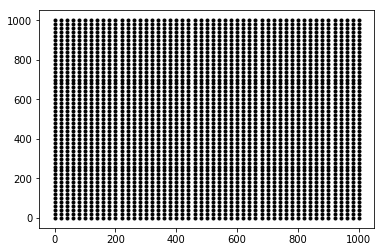

In [2]:
boundaries = {'top': 'closed', 'bottom': 'closed'}
grid = RasterModelGrid((51, 51), spacing=20.0, bc=boundaries)
plt.plot(grid.x_of_node, grid.y_of_node, 'k.')

Create some fields. These will include elevation (which doesn't do anything in the current version of the model, but we can use it assess the depth to the water table), the water table height, and the water table base. We'll set the elevation to a uniform 100 m. The water table will slope down from west to east by 10 m over 1 km. The water table height will be fixed at 90 m at the left (west) boundary, and at 80 m at the right (east). The base will likewise slope downward from 40 m at left to 30 m at right, so when the flow is steady, the aquifer has uniform thickness.

We give each field the name required by the GroundwaterDupuitPercolator component (otherwise, it won't recognize these as the proper fields).

In [3]:
elev = grid.add_zeros('node', 'topographic__elevation')
elev += 100
base = grid.add_zeros('node', 'aquifer_base__elevation')
base[:] = 40.0 - 0.01 * grid.x_of_node
wtable = grid.add_zeros('node', 'water_table__elevation')
wtable[:] = 90.0 - 0.01 * grid.x_of_node

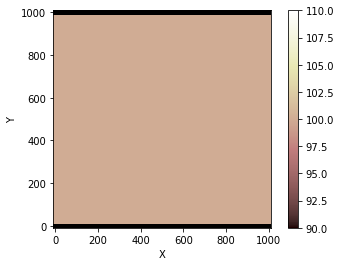

In [4]:
imshow_grid(grid, 'topographic__elevation')

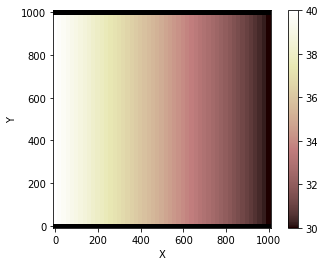

In [5]:
imshow_grid(grid, 'aquifer_base__elevation')

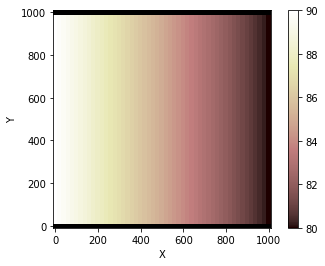

In [6]:
imshow_grid(grid, 'water_table__elevation')

We'll make an array for recharge rate, in meters per second. Initially, it will be all zeros; later, we'll add negative values to certain nodes to represent pumping. We'll make it a field so that if we later decide to write output to a file, it will be included.

In [7]:
recharge = grid.add_zeros('node', 'recharge_rate')

Next, make a component:

In [8]:
gdp = GroundwaterDupuitPercolator(grid, recharge_rate='recharge_rate', hydraulic_conductivity=0.01)

We can now run the component. If we've set everything up right, we should have a velocity from left to right of 0.0001 m/s. This comes from Darcy's law: we have a conductivity of 0.01 m/s (pretty conductive), and a gradient of -0.01; so minus conductivity times gradient gives 0.0001 m/s. Let's test it out.

In [9]:
gdp.run_one_step(1.0)
np.amax(gdp.vel)

0.00010000000000000143

The velocity should be 0.0001 at "horizontal" (east-west) links, and zero elsewhere. We can test this by inspecting just horizontal links (some will still have zero values; these are boundary links). We'll do the same for discharge too. It should be 0.0001 m/s times 50 m = 0.005 m2/s.

In [10]:
gdp.vel[grid.horizontal_links]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e-04,   1.00000000e-04,   1.00000000e-04, ...,
          1.00000000e-04,   1.00000000e-04,   1.00000000e-04],
       [  1.00000000e-04,   1.00000000e-04,   1.00000000e-04, ...,
          1.00000000e-04,   1.00000000e-04,   1.00000000e-04],
       ..., 
       [  1.00000000e-04,   1.00000000e-04,   1.00000000e-04, ...,
          1.00000000e-04,   1.00000000e-04,   1.00000000e-04],
       [  1.00000000e-04,   1.00000000e-04,   1.00000000e-04, ...,
          1.00000000e-04,   1.00000000e-04,   1.00000000e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [11]:
gdp.q[grid.horizontal_links]

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.005,  0.005,  0.005, ...,  0.005,  0.005,  0.005],
       [ 0.005,  0.005,  0.005, ...,  0.005,  0.005,  0.005],
       ..., 
       [ 0.005,  0.005,  0.005, ...,  0.005,  0.005,  0.005],
       [ 0.005,  0.005,  0.005, ...,  0.005,  0.005,  0.005],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

## Example 2: pumping

For the next example, we will put a pump in the middle of the domain, and withdraw 0.02 m3/s (about 1700 m3/day). We expect to see a cone of depression around the pump location.

In [12]:
gdp.recharge[1301] = -0.020
np.amin(gdp.wtable)

80.0

Now run the model for some period of time and look at the result:

In [13]:
dt = 100.0  # time step in seconds (rough guess at stability)
for i in range(10000):  # about 12 days
    gdp.run_one_step(dt)

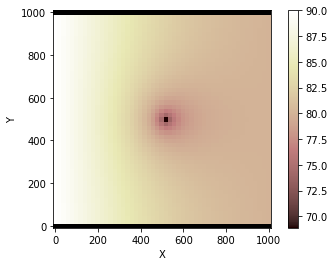

In [14]:
imshow_grid(grid, 'water_table__elevation')

In [15]:
np.amin(grid.at_node['water_table__elevation'])  # how low has water in the well gone?

68.888289270433461

Now turn off the pump and let the system recover:

In [16]:
gdp.recharge[1301] = 0.0
for i in range(100):
    gdp.run_one_step(dt)

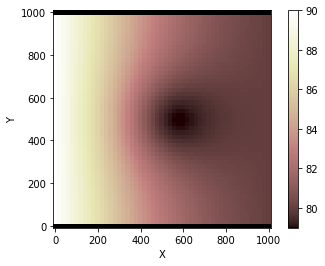

In [17]:
imshow_grid(grid, 'water_table__elevation')

In this example, we have used a high conductivity, so it responds quite quickly. Using a lower conductivity would produce a slower response, and would also allow larger time steps.

## Example 3: steady convex water table with recharge

In this example, we use a long, narrow domain, and set only the east boundary open. Steady, uniform recharge is applied. The expected analytical solution for the steady case is as follows. With a groundwater divide at the left boundary, the flow is to the right (increasing $x$). The input from recharge at a given position $x$ is:

$q_{in} = Rx$.

The output is given by Darcy's law:

$q_{out} = -K H \frac{dH}{dx} = -\frac{K}{2}\frac{dH^2}{dx}$.

Setting the two equal,

$\frac{dH^2}{dx} = -\frac{2R}{K} x$.

As a boundary condition, we'll say that the water table height at the right side, a distance $L$ from the groundwater divide, is $H_L$. We can then integrate:

$\int_0^y x$

$\int_H^{H_L} dH^2 = -\frac{2R}{K} \int_x^L x dx$

$H_L^2 - H^2 = -\frac{R}{K} (L^2 - x^2)$

$H^2 = H_L^2 + \frac{R}{K} (L^2 - x^2)$

$H = \sqrt{H_L^2 + \frac{R}{K} (L^2 - x^2)}$.

For $H_L=0$, the expected height at the divide is $\sqrt{RL^2/K}$, and the equation can be nondimensionalized as:

$H' = \frac{H}{\sqrt{RL^2/K}} = \sqrt{(1 - x'^2)}$, for $0 \le x \le 1$.

We can visualize the solution:


Text(0, 0.5, "H'")

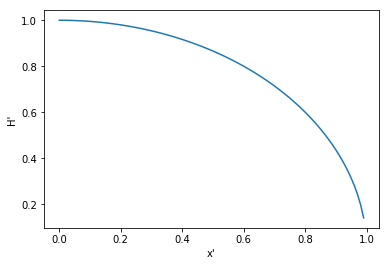

In [25]:
xprime = np.arange(0, 1, 0.01)
hprime = np.sqrt(1.0 - xprime * xprime)
plt.plot(xprime, hprime)
plt.xlabel("x'")
plt.ylabel("H'")

The curve looks this way because as you go left to right, the system needs to carry more water, yet it is thinner, so it has to increase the water-table slope to compensate.

We'll configure a dimensional version of this with the GroundwaterDupuitPercolator component.

In [26]:
R = 1.0e-7  # steady, uniform recharge rate, in m/s
K = 0.0001  # uniform hydraulic conductivity, in m/s
L = 1000.0  # domain length, m
HL = 10.0   # aquifer thickness at right boundary, m

H0 = (HL * HL + (R / K) * (L * L)) ** 0.5
print('Predicted water table height at divide, meters: ' + str(H0))

Predicted water table height at divide, meters: 33.166247903553995


In [33]:
boundaries = {'top': 'closed', 'left': 'closed', 'bottom': 'closed'}
grid2 = RasterModelGrid((5, 41), spacing=25.0, bc=boundaries)
elev2 = grid2.add_zeros('node', 'topographic__elevation')
elev2[:] = 35.0
base2 = grid2.add_zeros('node', 'aquifer_base__elevation')
wt2 = grid2.add_zeros('node', 'water_table__elevation')
wt2[:] = HL
gdp2 = GroundwaterDupuitPercolator(grid2, hydraulic_conductivity=K, recharge_rate=R)

Text(0, 0.5, 'Water table height (m)')

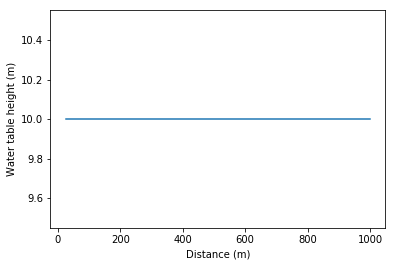

In [34]:
middle_row = np.where(grid2.y_of_node == 75.0)[0][1:]
plt.plot(grid2.x_of_node[middle_row], wt2[middle_row])
plt.xlabel('Distance (m)')
plt.ylabel('Water table height (m)')

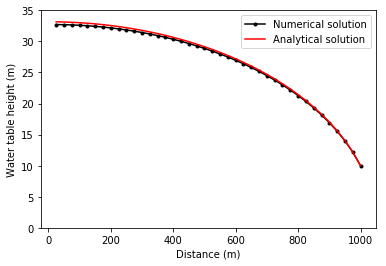

In [35]:
dt = 8.0e4
for i in range(10000):
    gdp2.run_one_step(dt)
plt.plot(grid2.x_of_node[middle_row], wt2[middle_row], 'k.-')
plt.xlabel('Distance (m)')
plt.ylabel('Water table height (m)')
plt.ylim([0.0, 35.0])
x = grid2.x_of_node[middle_row]
y = (HL * HL + (R/K)*(L*L - x*x))**0.5
plt.plot(x, y, 'r')
plt.legend(['Numerical solution', 'Analytical solution'])

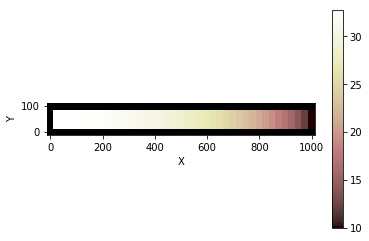

In [36]:
imshow_grid(grid2, wt2)